In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.cross_validation import train_test_split
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Train and predict categories for all crime types:

In [2]:
#load train
train = pd.read_csv('/home/ubuntu/Notebooks/SFCRIME/input/SFPD_CRIME.csv', parse_dates=['Date','Time'])

In [3]:
train['Year'] = train['Date'].apply(lambda x: x.strftime('%Y'))
train['Hour'] = train['Time'].apply(lambda x: x.hour)
train['Week'] = train['Date'].apply(lambda x:x.week)
train['Month'] = train['Date'].apply(lambda x:x.month)
train['day'] = train['Date'].apply(lambda x:x.day)
train['week_number'] = pd.to_datetime(train['Date'], format="%m/%d/%Y").apply(lambda x: x.isocalendar()[1])

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024579 entries, 0 to 2024578
Data columns (total 19 columns):
IncidntNum     int64
Category       object
Descript       object
DayOfWeek      object
Date           datetime64[ns]
Time           datetime64[ns]
PdDistrict     object
Resolution     object
Address        object
X              float64
Y              float64
Location       object
PdId           int64
Year           object
Hour           int64
Week           int64
Month          int64
day            int64
week_number    int64
dtypes: datetime64[ns](2), float64(2), int64(7), object(8)
memory usage: 293.5+ MB


In [5]:
set(train['Category'])

{'ARSON',
 'ASSAULT',
 'BAD CHECKS',
 'BRIBERY',
 'BURGLARY',
 'DISORDERLY CONDUCT',
 'DRIVING UNDER THE INFLUENCE',
 'DRUG/NARCOTIC',
 'DRUNKENNESS',
 'EMBEZZLEMENT',
 'EXTORTION',
 'FAMILY OFFENSES',
 'FORGERY/COUNTERFEITING',
 'FRAUD',
 'GAMBLING',
 'KIDNAPPING',
 'LARCENY/THEFT',
 'LIQUOR LAWS',
 'LOITERING',
 'MISSING PERSON',
 'NON-CRIMINAL',
 'OTHER OFFENSES',
 'PORNOGRAPHY/OBSCENE MAT',
 'PROSTITUTION',
 'RECOVERED VEHICLE',
 'ROBBERY',
 'RUNAWAY',
 'SECONDARY CODES',
 'SEX OFFENSES, FORCIBLE',
 'SEX OFFENSES, NON FORCIBLE',
 'STOLEN PROPERTY',
 'SUICIDE',
 'SUSPICIOUS OCC',
 'TREA',
 'TRESPASS',
 'VANDALISM',
 'VEHICLE THEFT',
 'WARRANTS',
 'WEAPON LAWS'}

Too many categories, I'll have to manually pair them down.

In [6]:
# violent = ['ASSAULT','SEX OFFENSES FORCIBLE','SEX OFFENSES NON FORCIBLE','ROBBERY','KIDNAPPING','SEX OFFENSES, NON FORCIBLE','SEX OFFENSES, FORCIBLE']

# non_violent = ['SUICIDE','SUSPICIOUS OCC','LARCENY/THEFT','DRUNKENNESS','DRIVING UNDER THE INFLUENCE','DISORDERLY CONDUCT']

# property_ = ['VANDALISM','VEHICLE THEFT','TRESPASS','STOLEN PROPERTY','RECOVERED VEHICLE','ARSON','BURGLARY',]

# other = ['NON-CRIMINAL','SECONDARY CODES','RUNAWAY','OTHER OFFENSES', 'MISSING PERSON','LOITERING','TREA']

# illegal = ['GAMBLING','DRUG/NARCOTIC','WARRANTS','PORNOGRAPHY/OBSCENE MAT','LIQUOR LAWS','FRAUD','FAMILY OFFENSES','WEAPON LAWS']

# criminal_acts = ['EMBEZZLEMENT','BAD CHECKS','BRIBERY','PROSTITUTION','EXTORTION','FORGERY/COUNTERFEITING']

# len(violent)+len(non_violent)+len(property_)+len(other)+len(illegal)+len(criminal_acts)

In [7]:
# for v in violent:
#     train.loc[train['Category']==v,'Category']='violent'
# for v in non_violent:
#     train.loc[train['Category']==v,'Category']='non_violent'
# for v in property_:
#     train.loc[train['Category']==v,'Category']='property_'
# for v in other:
#     train.loc[train['Category']==v,'Category']='other'
# for v in illegal:
#     train.loc[train['Category']==v,'Category']='illegal'
# for v in criminal_acts:
#     train.loc[train['Category']==v,'Category']='criminal_acts'

## Now there are only six categories

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


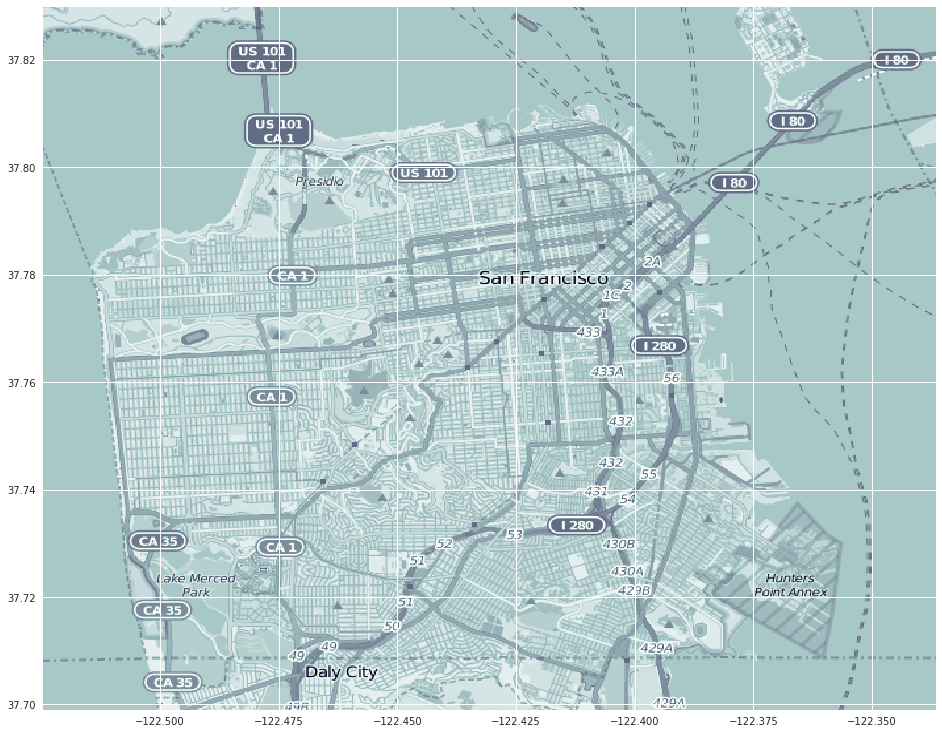

In [8]:
SF_map= np.loadtxt("input/sf_map_copyright_openstreetmap_contributors.txt")
# Supplied map bounding box:
#    ll.lon     ll.lat   ur.lon     ur.lat
#    -122.52469 37.69862 -122.33663 37.82986
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
asp = SF_map.shape[0] * 1.0 / SF_map.shape[1]
fig = plt.figure(figsize=(16,16))
plt.imshow(SF_map,cmap='bone',extent=lon_lat_box,aspect=1/asp)
ax= plt.gca()

## Plot training data

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


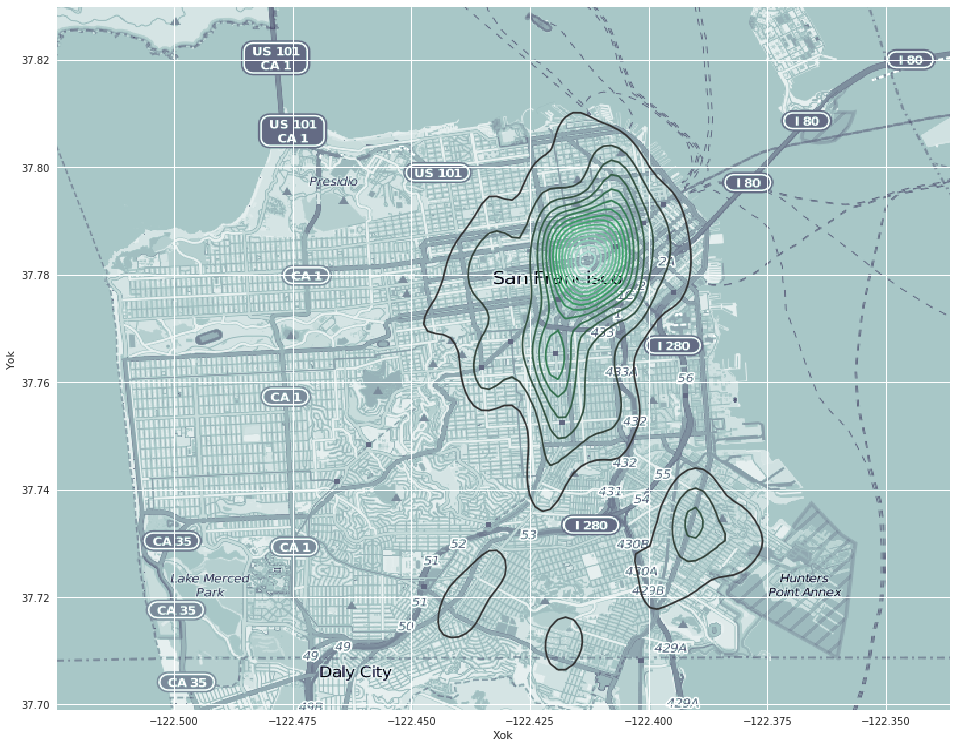

In [10]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns
import zipfile
pl.figure(figsize=(20,10))
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

SF_map= np.loadtxt("input/sf_map_copyright_openstreetmap_contributors.txt")

asp = SF_map.shape[0] * 1.0 / SF_map.shape[1]
fig = pl.figure(figsize=(16,16))

plt.imshow(SF_map,cmap='bone',extent=lon_lat_box,aspect=1/asp)
ax= plt.gca()

asp = 1
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

train['Xok'] = train[train.X<-122].X
train['Yok'] = train[train.Y<40].Y

train = train.dropna()
train_cat = train[train.Category == 'ASSAULT'] 
train_cat = train_cat[0:3000]
ax = sns.kdeplot(train_cat.Xok, train_cat.Yok,n_levels=20, clip=clipsize, aspect=1/asp)
ax= pl.gca()
pl.show()

## Explore Data

In [11]:
train['Category'].value_counts()

LARCENY/THEFT                  422337
OTHER OFFENSES                 286784
NON-CRIMINAL                   216829
ASSAULT                        177470
VEHICLE THEFT                  119834
DRUG/NARCOTIC                  115142
VANDALISM                      104289
WARRANTS                        94966
BURGLARY                        84047
SUSPICIOUS OCC                  73026
MISSING PERSON                  59478
ROBBERY                         51694
FRAUD                           38311
SECONDARY CODES                 23269
FORGERY/COUNTERFEITING          22355
WEAPON LAWS                     20077
TRESPASS                        17477
PROSTITUTION                    16161
STOLEN PROPERTY                 10890
SEX OFFENSES, FORCIBLE          10404
DISORDERLY CONDUCT               9575
DRUNKENNESS                      9434
RECOVERED VEHICLE                8058
DRIVING UNDER THE INFLUENCE      5302
KIDNAPPING                       5075
RUNAWAY                          4114
LIQUOR LAWS 

In [12]:
train['count'] = 1

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


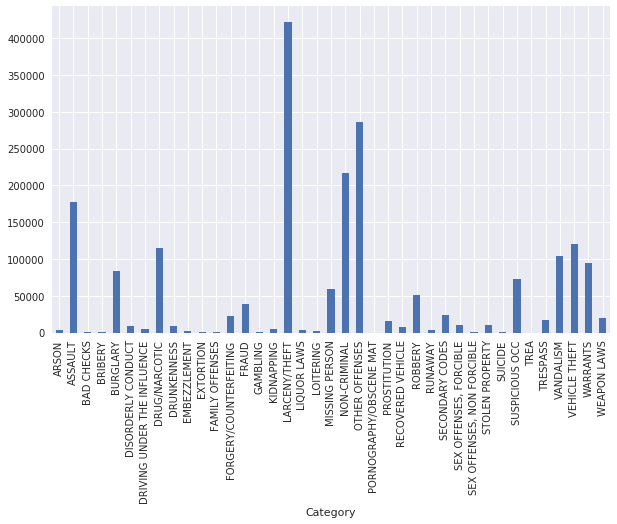

In [13]:
train.groupby(['Category'])['count'].sum().plot(kind = 'bar',figsize = (10,6))

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


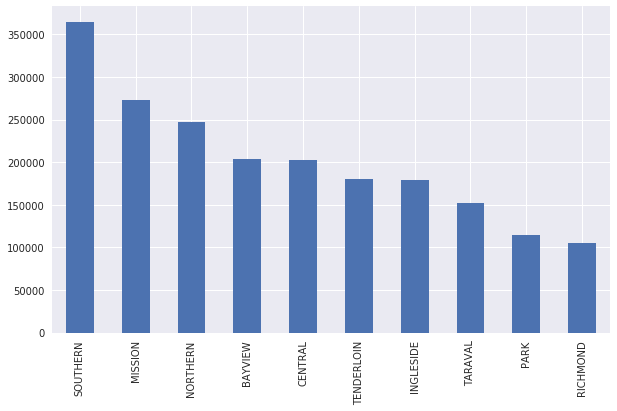

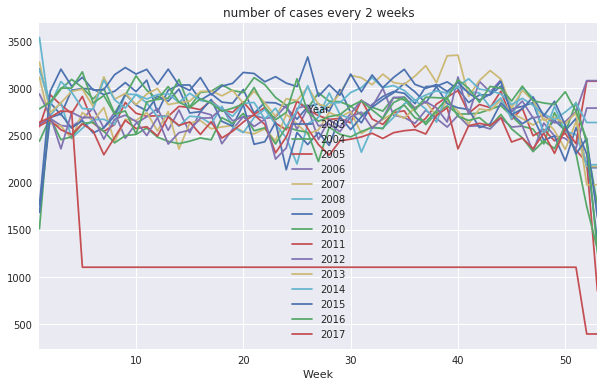

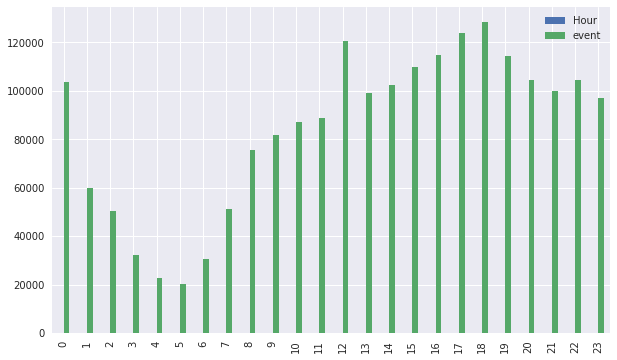

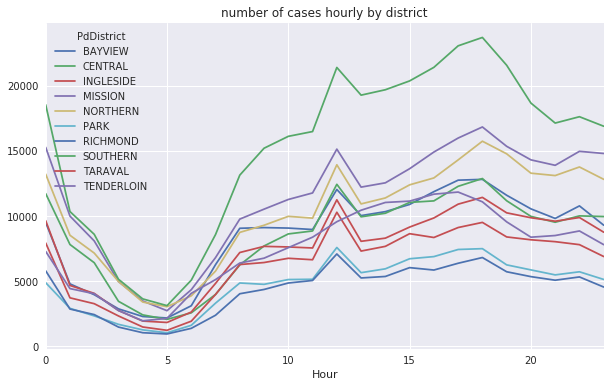

In [14]:
train.PdDistrict.value_counts().plot(kind='bar', figsize=(10,6))
train['event']=1
weekly_events = train[['Week','Year','event']].groupby(['Year','Week']).count().reset_index()
weekly_events_years = weekly_events.pivot(index='Week', columns='Year', values='event').fillna(method='ffill')
#%matplotlib inline'
ax = weekly_events_years.interpolate().plot(title='number of cases every 2 weeks', figsize=(10,6))

hourly_events = train[['Hour','event']].groupby(['Hour']).count().reset_index()
hourly_events.plot(kind='bar', figsize=(10, 6))

hourly_district_events = train[['PdDistrict','Hour','event']].groupby(['PdDistrict','Hour']).count().reset_index()
hourly_district_events_pivot = hourly_district_events.pivot(index='Hour', columns='PdDistrict', values='event').fillna(method='ffill')
hourly_district_events_pivot.interpolate().plot(title='number of cases hourly by district', figsize=(10,6))

## Predict Crimes

In [15]:
X = train[['X', 'Y','Week','Month','Hour','day']]
y = train['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=86)

In [16]:
import xgboost
xgb = xgboost.XGBClassifier(learning_rate=0.001,max_depth=4,missing=None, n_estimators=400, nthread=-1)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.001, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [17]:
# make predictions for test` data
y_pred= xgb.predict(X_test)
y_proba= xgb.predict_proba(X_test)

In [18]:
from sklearn.metrics import roc_auc_score, classification_report
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00      1041
                    ASSAULT       0.22      0.00      0.01     53122
                 BAD CHECKS       0.00      0.00      0.00       281
                    BRIBERY       0.00      0.00      0.00       233
                   BURGLARY       0.00      0.00      0.00     25240
         DISORDERLY CONDUCT       0.00      0.00      0.00      2798
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00      1639
              DRUG/NARCOTIC       0.23      0.35      0.28     34710
                DRUNKENNESS       0.00      0.00      0.00      2890
               EMBEZZLEMENT       0.00      0.00      0.00       845
                  EXTORTION       0.00      0.00      0.00       210
            FAMILY OFFENSES       0.00      0.00      0.00       351
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      6694
                      FRAUD      

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[  0,   2,   0, ...,   0,   0,   0],
       [  0, 224,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,  22,   0, ...,   0,   0,   0],
       [  0,  37,   0, ...,   0,   0,   0],
       [  0,  10,   0, ...,   0,   0,   0]])

In [20]:
from sklearn.metrics import accuracy_score,f1_score
print(accuracy_score(y_test, y_pred))
f1_score(y_test,y_pred,average= 'weighted')

0.243969104162


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.13834539867832271

# Plot Crime predictions

In [ ]:
from mpl_toolkits.basemap import Basemap
pl.figure(figsize=(20,10))
SF_map= np.loadtxt("input/sf_map_copyright_openstreetmap_contributors.txt")
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
asp = SF_map.shape[0] * 1.0 / SF_map.shape[1]
fig = plt.figure(figsize=(16,16))
plt.imshow(SF_map,cmap='bone',extent=lon_lat_box,aspect=1/asp)
ax= plt.gca()
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]
test_cat = X_test[y_pred == 'non_violent'] 
Xok = test_cat.X
Yok = test_cat.Y
test_cat = test_cat.dropna()
asp =1
ax = sns.kdeplot(Xok, Yok,n_levels=20, clip=clipsize, aspect=1/asp)
ax = plt.gca()
plt.show()

## ROC CURVE

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


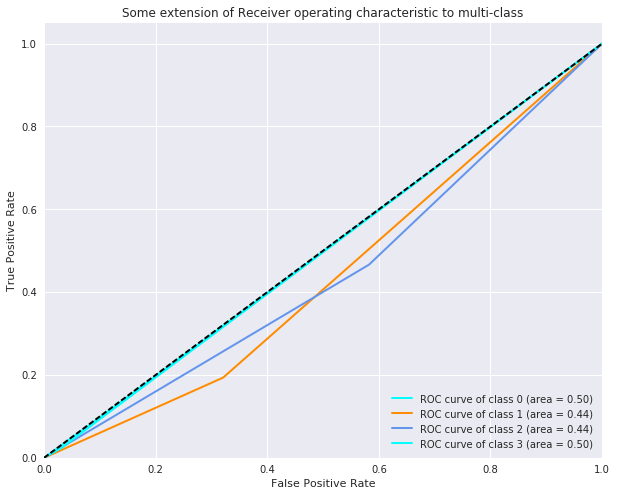

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve,auc
from itertools import cycle
lw = 2
plt.figure(figsize = (10,8))

y_test_2 = pd.get_dummies(y_test)
y_score = pd.get_dummies(y_pred)

n_classes = len(set(y_pred))

# Compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_2.iloc[:, i], y_score.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [21]:
(0.5 + 0.44 + 0.44 + 0.5)/4

0.47

## Precision-Recall Curve

In [26]:
import numpy as np
from sklearn.metrics import average_precision_score

def pr_curve(classi,truthvec,scorevec, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)
    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec, lw=lw,
             label='Precision-Recall curve class:{} ,average precision score:{:10.4f}'.format(classi,average_precision_score(y_test_2.iloc[:, classi],y_score.iloc[:, classi])))

    return(recallvec, precisionvec, threshvec)

def log_lik_binary(truthvec, probvec):
    return np.sum((np.log(probvec)*truthvec) + (np.log(1-probvec)*(1-truthvec)))

IndexError: single positional indexer is out-of-bounds

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


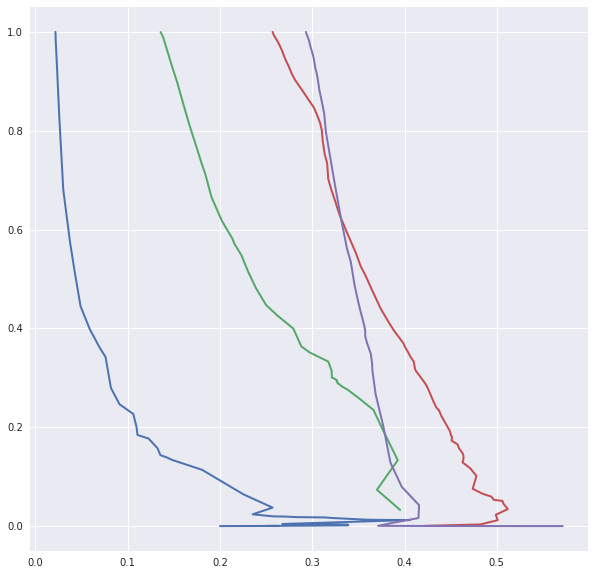

In [28]:
plt.figure(figsize = (10,10))
for i in range(y_test_2.shape[1]):
    asd= pr_curve(i,y_test_2.iloc[:,i],y_proba[:,i], digit_prec=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="best")

In [ ]:
y_test_2

In [ ]:
#thresholds for all crime times! prioritize crime...

In [ ]:
#dollar for a dispatch ---save money with prioritize dispatch of police

In [ ]:
y_proba[10,:]

In [ ]:
np.sum(y_proba[:,0] > 0.4)

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = ('criminal_acts','illegal', 'non_violent', 'other', 'violent', 'property')
y_pos = np.arange(len(objects))
plt.barh(y_pos, y_proba[10,:], align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Crime Probability')
plt.show()

In [ ]:
sum(y_test_2['violent'])/y_test_2.shape[0]

In [ ]:
sum(y_test_2['non_violent'])/y_test_2.shape[0]

In [ ]:
sum(y_test_2['property_'])/y_test_2.shape[0]

In [ ]:
sum(y_test_2['other'])/y_test_2.shape[0]

In [ ]:
sum(y_test_2['illegal'])/y_test_2.shape[0]

In [ ]:
sum(y_test_2['criminal_acts'])/y_test_2.shape[0]

In [ ]:
xgb.feature_importances_

In [ ]:
import ml_insights as mli
fig, ax = plt.subplots()
ind = np.array(range(len(X.columns)))+.7
plt.barh(ind,xgb.feature_importances_);
ax.set_yticks(ind + .3);
ax.set_yticklabels((X_test.columns))
plt.title('Feature Importance')

In [ ]:
mxr = mli.ModelXRay(xgb,X_test)
indices = mxr.feature_dependence_plots(num_pts=3, figsize = (20,20))

In [ ]:
pickle.load(open('crime_model.pkl'),'r')

In [ ]:
# clf = ensemble.GradientBoostingClassifier(n_estimators=100)    
# clf_cv_mli = mli.SplineCalibratedClassifierCV(clf, cv=3)
# clf_cv_mli.fit(X_train, y_train)
# probas_cv_mli = clf_cv_mli.predict_proba(X_test)
# cv_score_mli = log_loss(y_test, probas_cv_mli)

# clf = ensemble.GradientBoostingClassifier(n_estimators=100)    
# clf_cv = CalibratedClassifierCV(clf, cv=3, method='isotonic')
# clf_cv.fit(X_train, y_train)
# probas_cv = clf_cv.predict_proba(X_test)
# cv_score = log_loss(y_test, probas_cv)

# clf = ensemble.GradientBoostingClassifier(n_estimators=100)
# clf.fit(X_train, y_train)
# probas = clf.predict_proba(X_test)
# clf_score = log_loss(y_test, probas) 

# clf = ensemble.GradientBoostingClassifier(n_estimators=100)    
# clf_cv_mli = mli.SplineCalibratedClassifierCV(clf, cv=10)
# clf_cv_mli.fit(X_train, y_train)
# probas_cv_mli = clf_cv_mli.predict_proba(X_test)
# cv_score_mli_10 = log_loss(y_test, probas_cv_mli)
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(n_estimators=10)    
clf_cv = CalibratedClassifierCV(clf, cv=10, method='isotonic')
clf_cv.fit(X_train, y_train)
probas_cv = clf_cv.predict_proba(X_test)
cv_score_10 = log_loss(y_test, probas_cv)

print('\nuncalibrated score: {}'.format(clf_score))
print('\ncalibrated score isotonic-sklearn (3-fold): {}'.format(cv_score))
print('calibrated score mli (3-fold): {}'.format(cv_score_mli))
print('\ncalibrated score isotonic-sklearn (10-fold): {}'.format(cv_score_10))
print('calibrated score mli (10-fold): {}\n'.format(cv_score_mli_10))

In [ ]:
correlations = X.corr()
# plot correlation matrix
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap='Blues')
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.title('Correlations of features used')
plt.show()

In [ ]:
X.corr().plot(kind = 'bar',figsize=(10, 4))

In [ ]:
train.groupby('X')['count'].sum().sort_values(ascending = False).idxmax()

In [ ]:
train.groupby('Y')['count'].sum().sort_values(ascending = False).idxmax()

In [ ]:
X_user, Y_user,week_user,hour_user,day_user = -122.425892, 37.774599, 14, 23, 5

In [ ]:
def check_user_sf(X_user,Y_user):
    X_limit_right = -122.35
    X_limit_left = -122.51
    Y_limit_top = 37.82
    Y_limit_bottom = 37.68
    if ((X_user  < X_limit_right) & (X_user> X_limit_left)& (Y_user < Y_limit_top) & (Y_user>Y_limit_bottom )):
        print('It looks like you\'re in San Francisco, unfortunately...')
        return True
    else:
        print('You\'re not in San Francisco!')
        return False

In [ ]:
def plot_probs_user(X_user, Y_user,week_user,hour_user,day_user):
    #Plots the probability of a users crime--at
    import matplotlib.pyplot as plt; plt.rcdefaults()
    import numpy as np
    import matplotlib.pyplot as plt
    if check_user_sf(X_user,Y_user) == True:
        array_user = pd.Series(data=[X_user, Y_user,week_user,hour_user,day_user],index=['X', 'Y', 'Week', 'Hour', 'day'])
        array_user=pd.DataFrame(array_user).T
        prob_user = xgb.predict_proba(array_user)
        objects = ('criminal_acts','illegal', 'non_violent', 'other', 'violent', 'property')
        y_pos = np.arange(len(objects))
        plt.barh(y_pos, prob_user[0], align='center', alpha=0.5)
        plt.yticks(y_pos, objects)
        plt.xlabel('Probability')
        plt.title('Crime Probability')
        plt.show()
        return prob_user
    else:
        print('Try another location!')

In [ ]:
plot_probs_user(-122.425892, 37.745599, 14, 23, 5)

In [ ]:
plot_probs_user(-122.74, 33.75, 14, 23, 5)

## Plot crime data for that location over all time...?

## compare all probabilities to baseline!!!

## look at crime over the past years/weeks for when day = day_user, hour = hour_user, and the positions are known. So look at each possible crime.

In [ ]:
pickle.dump( xgb, open( "crime_model.pkl", "wb" ),protocol=2)

In [ ]:
crime_model = pickle.load( open( "crime_model.pkl", "rb" ))